# Merging sealevel forecasts of a statistical model with a climate model

In [1]:
# first some libraries we need

# we check matplotlib version because we want styles (otherwise use mpltools)
from distutils.version import StrictVersion
import logging

import numpy as np

import matplotlib
import matplotlib.pyplot as plt
msg = "We need matplotlib.style which is not available before 1.4"
assert StrictVersion(matplotlib.__version__) >= StrictVersion('1.4.0'), msg
import matplotlib.style
# make R and python plots consistent
matplotlib.style.use('ggplot')

# turn on inline plots
%matplotlib inline

# we want interactive models
from IPython.html.widgets import interact, interactive
# and we want to display multiple formulas
from IPython.display import display

# and we're doing some symbolic math
import sympy
from sympy import init_printing, pprint, oo, lambdify 
from sympy.stats import Normal, density, E, variance
init_printing(use_latex=True)

# and statistics
import scipy.stats

# and tables
import pandas

# and xml
import lxml.etree


# Bayesian inference

In [2]:
# let's use two distributions as an example
# how can we add the evidence of a to b
mu_a =  3
mu_b = 4
sigma_a = 0.5
sigma_b = 1
x = np.linspace(0,10, num=100)


<function __main__.plot>

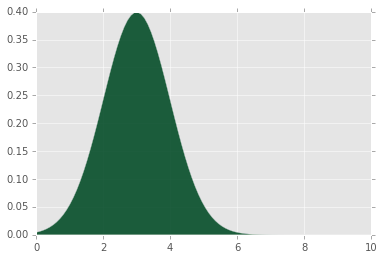

In [3]:
# Let's assume both are normal distributions
# When you add two distributions y
# The resulting distribution is the distribution that x can take when a new population is the combined population of 
# both populations
# For example suppose we have a distribution of adult men, with a mean of 1.8m and standard deviation of 0.2m and we combine that 
# with the population of children between 0 and 1 we get a double peaked distribution. 
# Not to be confused with the distribution we get when the population of adult men, all raise the babies above their add.
# The sum of two normal distributed variables is a normal distribution. 
# The sum of two normal probability density functions is not normal.

def plot(mu_a, sigma_a, mu_b, sigma_b):
    N_a = scipy.stats.norm(scale=sigma_a, loc=mu_a)
    N_b = scipy.stats.norm(scale=sigma_b, loc=mu_b)

    plt.fill_between(x, N_a.pdf(x), facecolor='blue', alpha=0.5)
    plt.fill_between(x, N_b.pdf(x), facecolor='black', alpha=0.5)
    plt.fill_between(x, (N_a.pdf(x) + N_b.pdf(x))/2.0, facecolor='green', alpha=0.5)
interact(plot, mu_a=(1,5), mu_b=(1,5), sigma_a=(0,2.0), sigma_b=(0,2.0))

<function __main__.plot>

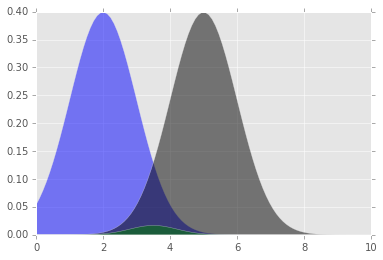

In [4]:
# When combining model results one is more often interested in 
# the combination of two distributions in a multiplicative way. 

def plot(mu_a, sigma_a, mu_b, sigma_b):
    N_a = scipy.stats.norm(scale=sigma_a, loc=mu_a)
    N_b = scipy.stats.norm(scale=sigma_b, loc=mu_b)
    plt.fill_between(x, N_a.pdf(x), facecolor='blue', alpha=0.5)
    plt.fill_between(x, N_b.pdf(x), facecolor='black', alpha=0.5)
    plt.fill_between(x, (N_a.pdf(x) * N_b.pdf(x)), facecolor='green', alpha=0.5)
    
interact(plot, mu_a=(0,5), mu_b=(0,10), sigma_a=(0,2.0), sigma_b=(0,2.0))

# the resulting function is not normalized yet. It's normal but the integral does not add to 1.
# We have to apply the normalizing constant


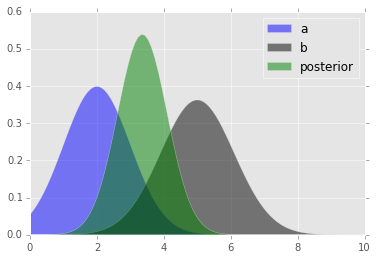

In [5]:
# here we use the distribution that you get by applying normalizing constant
from matplotlib.patches import Rectangle 
def plot(mu_a, sigma_a, mu_b, sigma_b):
    N_a = scipy.stats.norm(scale=sigma_a, loc=mu_a)
    N_b = scipy.stats.norm(scale=sigma_b, loc=mu_b)
    mu_post = (sigma_a**2*mu_b + sigma_b**2*mu_a)/(sigma_a**2 + sigma_b**2)
    sigma_post = (1/(1/sigma_a**2 + 1/sigma_b**2))**0.5
    N_post = scipy.stats.norm(scale=sigma_post, loc=mu_post)
    x = np.linspace(0,10, num=100)
    plt.fill_between(x, N_b.pdf(x), facecolor='blue', alpha=0.5, label='prior')
    plt.fill_between(x, N_a.pdf(x), facecolor='black', alpha=0.5, label='data')
    plt.fill_between(x, N_post.pdf(x), facecolor='green', alpha=0.5, label='posterior')
    ra = Rectangle((0, 0), 1, 1, facecolor='blue', alpha=0.5) # creates rectangle patch for legend use. 
    rb = Rectangle((0, 0), 1, 1, facecolor='black', alpha=0.5) # creates rectangle patch for legend use. 
    rc = Rectangle((0, 0), 1, 1, facecolor='green', alpha=0.5) # creates rectangle patch for legend use. 
    plt.legend([ra, rb, rc], ['a', 'b', 'posterior'], loc='best')
    plt.xlim(0,10)
    plt.ylim(0,0.6)
interact(plot, mu_a=(0,5), mu_b=(0,5), sigma_a=(0,3.0), sigma_b=(0,3.0))


In [6]:
a, b, x, y = sympy.symbols('a b x y')
sigma_a = sympy.Symbol('sigma_a', positive=True)
sigma_b = sympy.Symbol('sigma_b', positive=True)
mu_a = sympy.Symbol('mu_a')
mu_b = sympy.Symbol('mu_b')
N_a = sympy.stats.Normal('N_a', mu_a, sigma_a)
N_b = sympy.stats.Normal('N_a', mu_b, sigma_b)
pdf_a = density(N_a)(x)
pdf_b = density(N_b)(x)

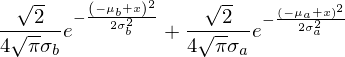

<function __main__.formula>

In [7]:
# todo: use bayes inference formula
def formula(mu_a, sigma_a, mu_b, sigma_b):
    pdf = pdf_a.subs({mu_a: mu_a, sigma_a: sigma_a})/2 + pdf_b.subs({mu_b:mu_b, sigma_b: sigma_b})/2
    display(pdf)
    try:
        cdf = pdf.integrate((x, -oo, oo)).simplify()
        display(cdf)
    except OverflowError:
        logging.exception('Overflow')
    except ValueError:
        logging.warn('no integral computed')
        
interact(formula, mu_a=(0,2.0), sigma_a=(1,3.0), mu_b=(0,2.0), sigma_b=(1,3.0))

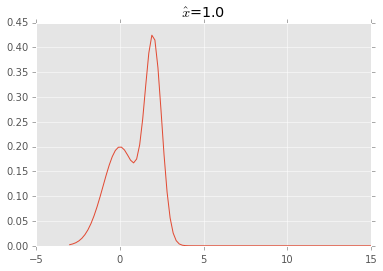

In [8]:
# for comparison, this is the pdf of adding two models
# suppose you have a model for surge and a model for tide, adding these two gives the distribution of tide + surge
pdf = pdf_a.subs({mu_a: 0, sigma_a: 1})/2 + pdf_b.subs({mu_b:2, sigma_b: 0.5})/2
pdf.integrate((x, -oo, oo)).simplify()
X = np.linspace(-3,15, num=100)
d = lambdify(x, pdf, np)(X)
plt.title('$\hat{x}$=%.1f' % (np.sum(X*d)/np.sum(d)).item())
plt.plot(X,d)


https://en.wikipedia.org/wiki/Maximum_a_posteriori_estimation

https://en.wikipedia.org/wiki/Mixture_model


# Reading model output

In [14]:
# read the model results into a data frame
# the knmi model is the climate model
knmi = pandas.read_csv('/Users/baart_f/src/sealevel/report/2014/knmi/KNMI14_sealevel_scenarios_by_1year_3polfit.csv')
knmi = knmi.set_index(['year'])


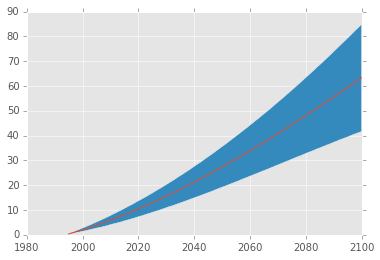

In [15]:
knmi['mean'] = (knmi['low_05'] + knmi['high_95'])/2.0
sigma_times_z90 = knmi['high_95'] - knmi['mean']
N = scipy.stats.norm(scale=1, loc=0)
knmi['std'] = sigma_times_z90/N.ppf(0.95)
plt.fill_between(knmi.index, knmi['mean'] - knmi['std'], knmi['mean'] + knmi['std'])
plt.plot(knmi.index, knmi['mean'])

In [17]:
# we now have the distributions of the probabilities
knmi = knmi.reset_index()
knmi['mean']/=100.0
knmi['mean']+= 0.045
knmi['std']/=100.0


In [18]:
# now use the data from hkv (the probabilistic model)

hkv1 = pandas.read_csv('/Users/baart_f/src/sealevel/report/2014/hkv/data/full_output_station_gemiddeld.csv', sep=';')
hkv1 = hkv1[['year', 'wlevl','lm.pred.clim.low','lm.pred.clim.high']]
# wlevel is missing here
hkv2 = pandas.read_csv('/Users/baart_f/src/sealevel/report/2014/hkv/data/full2_output_station_gemiddeld.csv', sep=';')
hkv = pandas.merge(hkv1, hkv2, how='outer', on=['year'])
hkv.columns
hkv['lm.pred.clim.low'] = np.where(hkv['year'] <= 2012, hkv['lm.pred.clim.low_x'], hkv['lm.pred.clim.low_y'])
hkv['lm.pred.clim.high'] = np.where(hkv['year'] <= 2012, hkv['lm.pred.clim.high_x'], hkv['lm.pred.clim.high_y'])

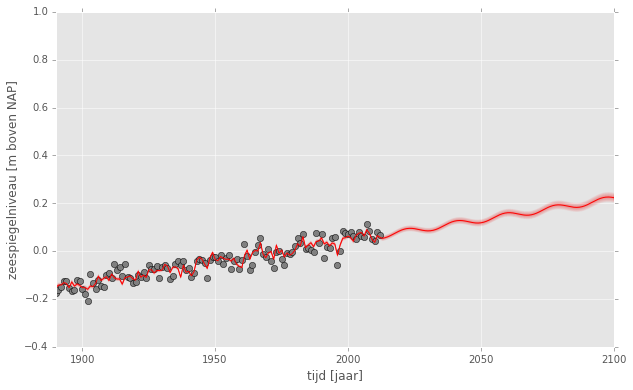

In [19]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(hkv['year'], hkv['wlevl'], 'o', label='waarnemingen', color='grey')
#ax.fill_between(hkv2['year'], hkv['lm.pred.clim.low'],  hkv['lm.pred.clim.high'], alpha=0.2)
ax.plot(hkv['year'], (hkv['lm.pred.clim.low'] + hkv['lm.pred.clim.high'])/2.0, color='red')

for i in np.linspace(0.1, 1.96, num=20):
    ax.fill_between(hkv['year'], 
                     (hkv['lm.pred.clim.low'] + hkv['lm.pred.clim.high'])/2.0 - hkv['lm.pred.clim.se'] * i ,
                     (hkv['lm.pred.clim.low'] + hkv['lm.pred.clim.high'])/2.0 + hkv['lm.pred.clim.se'] * i ,
                     color='red', alpha=0.02)
ax.set_xlim(1890,2100)
ax.set_ylim(-0.4, 1.0)
ax.set_ylabel('zeespiegelniveau [m boven NAP]')
ax.set_xlabel('tijd [jaar]')
plt.savefig('hkvlinear.pdf')

In [26]:
import scipy.stats
scipy.stats.norm.pdf(0)


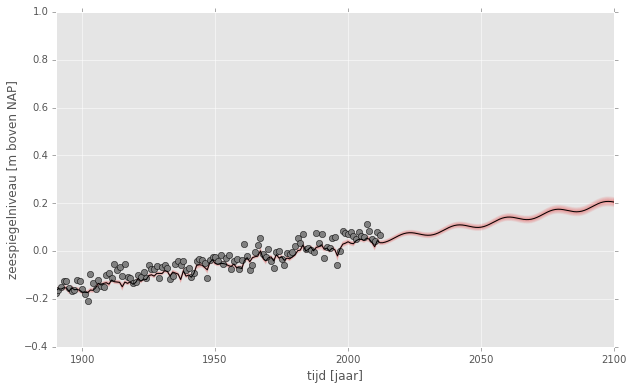

In [27]:
ci  = pandas.read_csv('../notebooks/ci.csv')
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(hkv['year'], hkv['wlevl'], 'o', label='waarnemingen', color='grey')
for i in np.linspace(0., 1.0, num=20):
    ax.fill_between(hkv['year'], 
                     ci['fit_linear']/1000 + ((ci['lwr_linear']/1000) - (ci['fit_linear']/1000) )*i  ,
                     ci['fit_linear']/1000 + ((ci['upr_linear']/1000) - (ci['fit_linear']/1000) )*i ,
                     color='red', alpha=0.02)
ax.plot(hkv['year'], ci['fit_linear']/1000, 'k-')

ax.set_xlim(1890,2100)
ax.set_ylim(-0.4, 1.0)
ax.set_ylabel('zeespiegelniveau [m boven NAP]')
ax.set_xlabel('tijd [jaar]')
plt.savefig('hkvlinear.pdf')

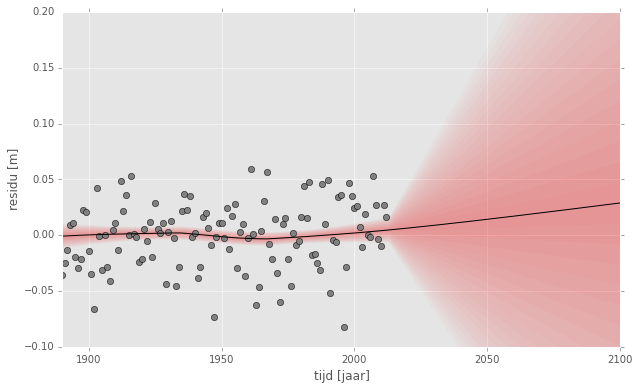

In [40]:
fig, ax = plt.subplots(figsize=(10,6))

ax.plot(hkv['year'], hkv['wlevl'] - hkv['lm.pred.fit'], 'o', label='waarnemingen', color='grey')
# extra standard error based on amsterdam records
se = np.r_[np.zeros(2013 - 1890), np.linspace(0, 0.179*(2101-2013)/100, num=2101 - 2013)]
ams = pandas.DataFrame(data=dict(year=np.arange(1890,2101), se=se))

for i in np.linspace(0., 1.0, num=20):
    ax.fill_between(hkv['year'], 
                     ci['fit_loess']/1000 + ((ci['lwr_loess']/1000) - (ci['fit_loess']/1000) )*i - se*i*1.96,
                     ci['fit_loess']/1000 + ((ci['upr_loess']/1000) - (ci['fit_loess']/1000) )*i + se*i*1.96,
                     color='red', alpha=0.02)
    
ax.plot(hkv['year'], ci['fit_loess']/1000.0, 'k-')
ax.set_xlim(1890, 2100)
ax.set_ylim(-0.1, 0.2)
ax.set_ylabel('residu [m]')
ax.set_xlabel('tijd [jaar]')
plt.savefig('resid.pdf')

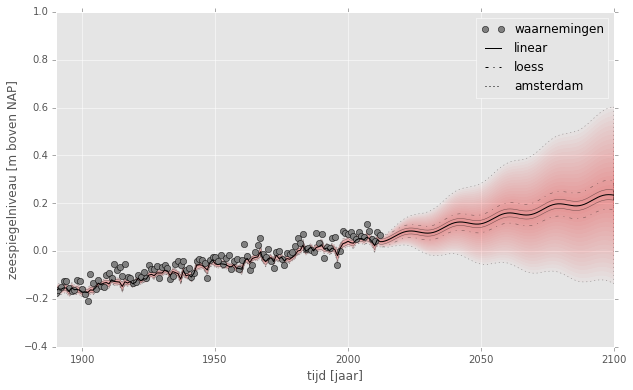

In [64]:
fig, ax = plt.subplots(figsize=(10,6))

ax.plot(hkv['year'], hkv['wlevl'] , 'o', label='waarnemingen', color='grey')

for i in np.linspace(0., 1.0, num=20):
    ax.fill_between(hkv['year'], 
                     ci['fit_loess']/1000 + ci['fit_linear']/1000 + ((ci['lwr_linear']/1000) - (ci['fit_linear']/1000) )*i + ((ci['lwr_loess']/1000) - (ci['fit_loess']/1000) )*i  - se*i*1.96,
                     ci['fit_loess']/1000 + ci['fit_linear']/1000 +((ci['upr_linear']/1000) - (ci['fit_linear']/1000) )*i + ((ci['upr_loess']/1000) - (ci['fit_loess']/1000) )*i + se*i*1.96,
                     color='red', alpha=0.02)

ax.fill_between(hkv['year'], 
                ci['fit_loess']/1000 + ci['fit_linear']/1000 + ((ci['lwr_linear']/1000) - (ci['fit_linear']/1000) ),
                ci['fit_loess']/1000 + ci['fit_linear']/1000 +((ci['upr_linear']/1000) - (ci['fit_linear']/1000) ),
                color='none', label='linear',
                edgecolor='black', alpha=0.5)
ax.plot(0,0,color='black', label='linear')
ax.fill_between(hkv['year'], 
                ci['fit_loess']/1000 + ci['fit_linear']/1000 + ((ci['lwr_linear']/1000) - (ci['fit_linear']/1000) ) + ((ci['lwr_loess']/1000) - (ci['fit_loess']/1000) )  ,
                ci['fit_loess']/1000 + ci['fit_linear']/1000 +((ci['upr_linear']/1000) - (ci['fit_linear']/1000) ) + ((ci['upr_loess']/1000) - (ci['fit_loess']/1000) ),
                color='none', label='linear',
                edgecolor='black', alpha=0.5, linestyle='-.')
ax.plot(0,0,color='black', label='loess', linestyle='-.')
ax.fill_between(hkv['year'], 
                ci['fit_loess']/1000 + ci['fit_linear']/1000 + ((ci['lwr_linear']/1000) - (ci['fit_linear']/1000) ) + ((ci['lwr_loess']/1000) - (ci['fit_loess']/1000) ) - se*1.96 ,
                ci['fit_loess']/1000 + ci['fit_linear']/1000 +((ci['upr_linear']/1000) - (ci['fit_linear']/1000) ) + ((ci['upr_loess']/1000) - (ci['fit_loess']/1000) ) + se*1.96,
                color='none', label='amsterdam',
                edgecolor='black', alpha=0.5, linestyle=':')
ax.plot(0,0,color='black', label='amsterdam', linestyle=':')

ax.plot(hkv['year'], ci['fit_loess']/1000.0 + ci['fit_linear']/1000.0, 'k-')

ax.set_xlim(1890,2100)
ax.set_ylim(-0.4, 1.0)
ax.set_ylabel('zeespiegelniveau [m boven NAP]')
ax.set_xlabel('tijd [jaar]')
ax.legend()
plt.savefig('hkv.pdf')



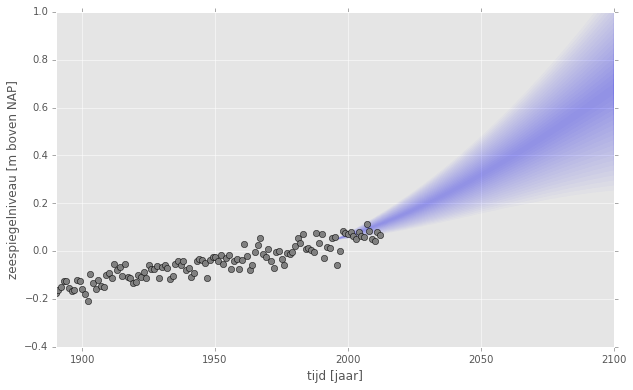

In [37]:
# now we can combine them
# plot them in the same chart
fig, ax = plt.subplots(figsize=(10,6))
#ax.set_ylim(-0.2,0.2)
#ax.set_xlim(1890,2020)
ax.plot(hkv['year'], hkv['wlevl'], 'o', color='grey')
#ax.fill_between(hkv['year'], hkv['pred.clim.mean'] - hkv['pred.clim.se'] * 1.96, hkv['pred.clim.mean'] + hkv['pred.clim.se'] * 1.96, alpha=0.2 , color='purple')
#axes[0].fill_between(hkv['year'], hkv['lm.pred.plim.low'], hkv['lm.pred.plim.high'])
for i in np.linspace(0.1, 1.96, num=20):
    ax.fill_between(
            knmi['year'], 
            knmi['mean'] - knmi['std']*i, 
            knmi['mean'] + knmi['std']*i , 
            alpha=0.02, color='blue' )
    
ax.set_xlim(1890,2100)
ax.set_ylim(-0.4, 1.0)
ax.set_ylabel('zeespiegelniveau [m boven NAP]')
ax.set_xlabel('tijd [jaar]')
plt.savefig('knmi.pdf')
# the climate model
# notice that the statistical model spreads out in the future


In [44]:
# merge and compute the posterior probability
ci['fit'] = ci['fit_linear'] + ci['fit_loess']
ci['se'] = (ci['upr_linear'] - ci['fit_linear'])/1.96


In [45]:
# merge and compute the posterior probability
ci['fit'] = (ci['fit_linear'] + ci['fit_loess'])/1000.0
ci['se'] = ((ci['upr_linear'] - ci['fit_linear'])/1000.0  + (ci['upr_loess'] - ci['fit_loess'])/1000.0) /1.96 + se
#plt.fill_between(ci['year'], ci['fit'] - ci['se']*1.96, ci['fit'] +ci['se']*1.96 )

merged = pandas.merge(ci[['year', 'fit', 'se']], knmi)
merged['mean.posterior'] = (
    merged['se']**2 * merged['mean'] + 
    merged['std']**2 * merged['fit']
    ) / (
    merged['se']**2 + merged['std']**2
    )
merged['sigma.posterior'] = (1/(1/merged['se']**2 + 1/merged['std']**2))**0.5


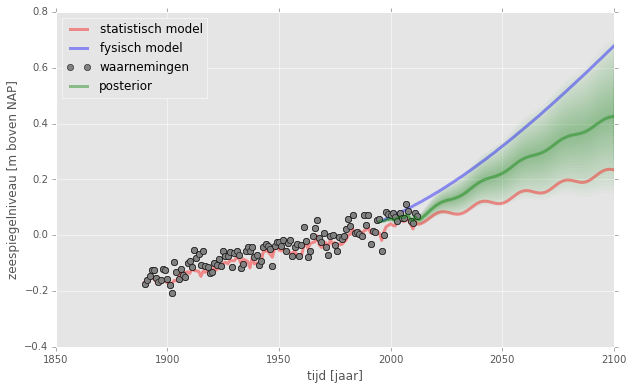

In [49]:
fig, ax = plt.subplots(1,1, figsize=(10,6))
ax.plot(hkv['year'], hkv['wlevl'], 'o', color='grey')

#for i in np.linspace(0., 1.0, num=20):
#    ax.fill_between(hkv['year'], 
#                     ci['fit_loess']/1000 + ci['fit_linear']/1000 + ((ci['lwr_linear']/1000) - (ci['fit_linear']/1000) )*i + ((ci['lwr_loess']/1000) - (ci['fit_loess']/1000) )*i - se*i*1.96 ,
#                     ci['fit_loess']/1000 + ci['fit_linear']/1000 +((ci['upr_linear']/1000) - (ci['fit_linear']/1000) )*i + ((ci['upr_loess']/1000) - (ci['fit_loess']/1000) )*i + se*i*1.96,
#                     color='red', alpha=0.02)

ax.plot(hkv['year'], ci['fit_loess']/1000.0 + ci['fit_linear']/1000.0, color='red', label='statistisch model', linewidth=3, alpha=0.4)

#for i in np.linspace(0.1, 1.96, num=20):
#    ax.fill_between(
#            knmi['year'], 
#            knmi['mean'] - knmi['std']*i, 
#            knmi['mean'] + knmi['std']*i , 
#            alpha=0.02, color='blue' )

ax.plot(knmi['year'], knmi['mean'], color='blue', label='fysisch model', linewidth=3, alpha=0.4)

for i in np.linspace(0.1, 1.96, num=20):
    ax.fill_between(merged['year'], 
                    merged['mean.posterior'] - merged['sigma.posterior']* i, 
                    merged['mean.posterior'] + merged['sigma.posterior']* i, alpha=0.02, color='green'
                    )

ax.plot(hkv['year'], hkv['wlevl'], 'o', label='waarnemingen', color='grey')
ax.plot(merged['year'], merged['mean.posterior'], 'g-', label='posterior', linewidth=3, alpha=0.4)

ax.set_xlabel('tijd [jaar]')
ax.set_ylabel('zeespiegelniveau [m boven NAP]')
ax.legend(loc='upper left')
#axes[1].plot(hkv['year'], hkv['speed'])
plt.savefig('merged.pdf')

In [ ]:
weight = np.zeros(1995-1890)
weight = np.r_[weight, np.linspace(0, 0.1, num=2013-1995)]
weight = np.r_[weight, np.linspace(0.1, 0.5, num=2043-2013)]
weight = np.r_[weight, np.linspace(0.5, 0.9, num=2063-2043)]
weight = np.r_[weight, np.linspace(0.9, 0.9, num=2101-2063)]
pandas.DataFrame(data=dict(year=np.arange(1890,2101), weight=weight))